# Stage Three: Part 1 - Creating Metabolic Models From Metabolomics Data

Modifed version of supplementary material from "Brunk, Elizabeth,et al. "Characterizing strain variation in engineered *E. coli* using a multi-omics-based workflow." Cell Systems 2.5 (2016): 335-346.

## Background

In this notebook we provide an example of taking multi-omics data and creating COBRA models for 9 different strains of *E. coli* (8 engineered strains and 1 wild-type, DH1, strain).

## Load the standard COBRApy and python packages

In [1]:
import os
%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from cobra.io.mat import load_matlab_model
from cobra.io.mat import save_matlab_model
from scipy.io import loadmat, savemat
from cobra.flux_analysis import variability

import theseus  

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_na',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager
import sys, os
 
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand
print("I'm using scipy version:", scipy.__version__)

I'm using scipy version: 1.7.3


## Set-up the directory links

In [2]:
# ROOT_DIR - root directory
ROOT_DIR = os.path.split(os.getcwd())[0]

#GEM Model file - can be a .xml or .mat file
EC_model =  ROOT_DIR + '/model_files/iJO1366.xml'
Engineered_model = ROOT_DIR + '/model_files/iJO1366_ENGINEERED.xml'

# Data dir
EC_data = ROOT_DIR + '/data/'

# MODEL_ORGANISM - the BRENDA organism string
EC_MODEL_ORGANISM = 'Escherichia coli'

In [3]:
ROOT_DIR = os.path.split(os.getcwd())[0]
EC_data

'C:\\Users\\a00016187\\Dropbox\\SB Course\\2022 Course\\OMICs/data/'

## Set-up the general COBRA model

#### (1) reconstruct engineered E. coli model (with heterologous pathway)

In [4]:
# make a mapping to header entries correspoding to keys of SteadyState_Dict to M reactIDs

rxn_name_map = {'Pyruvate': 'EX_pyr_e', 'biomass': 'Ec_biomass_iJO1366_core_53p95M','Acetyl-CoA':'EX_accoa_e', 'Glucose':'EX_glc_e', 'Mev-P':'EX_5pmev_e', 'GGPP':'EX_GGDP_e', 'Succinate':'EX_succ_e', 'HMG-coA':'EX_hmgcoa_e', 'hmbdp':'EX_h2mb4p_e', 'IPP/DMAPP':'IPP/DMAPP', 'Ethanol':'EX_etoh_e', 'Formate':'EX_for_e', 'Mevalonate':'EX_mev_e', 'Isopentenol':'EX_ipoh_e', 'IP':'EX_ip_e', 'dxyl5p':'EX_dxyl5p_e', 'FPP':'EX_frdp_e', 'Lactate':'EX_lac__D_e', 'GPP':'EX_grdp_e', '2mecdp':'EX_2mecdp_e', '4c2me':'EX_4c2me_e', 'Acetate':'EX_ac_e'}

##########################################################################################

# load in CSV files with info corresponding to new metabolites:
met_data = pd.read_csv('./model_files/metabolites.csv')
# load in CSV files with info corresponding to new reactions:
rxn_data = pd.read_csv('./model_files/reactions.csv')
# load in CSV files with info corresponding to new reactions bounds, reversibility, subsystems:
info_data = pd.read_csv('./model_files/info_reactions.csv')

##########################################################################################

# tell pandas to not fill in empty cells with "nan" - just leave them empty
rxn_data = rxn_data.fillna('')
info_data = info_data.fillna('')

### Show the contents of the metabolite, reaction and info data

The metabolite data shows all the metabolomic data gathered for the metabolites for each of the different strains (I1, I2,I3,L1, L2, L3, B1, B2, DH1)

In [5]:
met_data

,Unnamed: 0,formula,name
0,hmgcoa_c,C27H39N7O20P3S,3-Hydroxy-3-methyl-glutaryl-CoA
1,mev_R_c,C6H11O4,Mevalonate
2,5pmev_c,C6H10O7P,Mevalonate-5P
3,5dpmev_c,C6H10O10P2,Mevalonate-5PP
4,ipoh_c,C5H10O,Isopentenol
5,ip_c,C5H9O4P,Isopentenol-P
6,lim_c,C10H16,Limonene
7,bis_c,C15H24,Bisabolene
8,ggdp_c,C20H33O7P2,GeranylGeranyl-PP
9,ipoh_e,C5H10O,Isopentenol


The reaction data includes all the stochiometric data for the new reactions that need to be added to the iJO1366 standard model.

In [6]:
rxn_data

,Unnamed: 0,hmgcoa_c,mev_R_c,5pmev_c,5dpmev_c,ipoh_c,ip_c,lim_c,bis_c,aacoa_c,accoa_c,ipdp_c,grdp_c,ggdp_c,frdp_c,h_c,coa_c,nadp_c,nadph_c,adp_c,atp_c,pi_c,ppi_c,co2_c,h2o_c,dmpp_c,2mecdp_c,dxyl5p_c,h2mb4p_c,4c2me_c,ipoh_e,ipdp_e,dmpp_e,mev_R_e,5pmev_e,5dpmev_e,ip_e,2mecdp_e,dxyl5p_e,h2mb4p_e,grdp_e,frdp_e,ggdp_e,4c2me_e,bis_e,lim_e,coa_e,accoa_e,aacoa_e,hmgcoa_e,amp_e,adp_e,atp_e,nad_e,nadh_e,nadp_e,nadph_e,amp_c,nad_c,nadh_c
0,HMGS,-1.0,,,,,,,,1.0,1.0,,,,,-1.0,-1.0,,,,,,,,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,HMGR,1.0,-1.0,,,,,,,,,,,,,2.0,-1.0,-2.0,2.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,ERG1,,-1.0,1.0,,,,,,,,,,,,1.0,,,,1.0,-1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,ERG8,,,-1.0,1.0,,,,,,,,,,,,,,,1.0,-1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,MVD1,,,,-1.0,,,,,,,1.0,,,,,,,,1.0,-1.0,1.0,,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,NudB,,,,,,1.0,,,,,-1.0,,,,1.0,,,,,,1.0,,,-1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,UNK,,,,,1.0,-1.0,,,,,,,,,,,,,,,1.0,,,-1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,LIMS,,,,,,,1.0,,,,,-1.0,,,,,,,,,,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,BISS,,,,,,,,1.0,,,,,,-1.0,,,,,,,,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,YPL069C,,,,,,,,,,,-1.0,,1.0,-1.0,,,,,,,,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


The info data includes all the new reaction information that needs to be added to the original iJO1366 model.

In [7]:
info_data

,Reaction Abbreviation,Reaction Name,Formula,Gene-Protein-Reaction Association,Gene-Reaction Association,Protein-Reaction Association,Subsystem,EC Number,Reversible,Lower Bound,Upper Bound,Objective (c)
0,HMGS,hydroxymethylglutaryl-CoA synthase,coa[c] + h[c] + hmgcoa[c] <==> aacoa[c] + acco...,,,,isoprenoid biosynthesis,2.3.3.10,1,-1000,1000,0
1,HMGR,hydroxymethylglutaryl-CoA reductase,coa[c] + mev_R[c] + 2 nadp[c] <==> 2 h[c] + hm...,,,,isoprenoid biosynthesis,1.1.1.34,1,-1000,1000,0
2,ERG1,mevalonate kinase,atp[c] + mev_R[c] --> 5pmev[c] + adp[c] + h[c],,,,isoprenoid biosynthesis,2.7.1.36,0,0,1000,0
3,ERG8,phosphomevalonate kinase,5pmev[c] + atp[c] --> 5dpmev[c] + adp[c],,,,isoprenoid biosynthesis,2.7.4.2,0,0,1000,0
4,MVD1,diphosphomevalonate decarboxylase,5dpmev[c] + atp[c] --> adp[c] + co2[c] + ipdp[...,,,,isoprenoid biosynthesis,4.1.1.33,0,0,1000,0
5,NudB,dATP pyrophosphohydrolase,ipdp[c] + h2o[c] --> ip[c] + pi[c] + h[c],,,,isoprenoid biosynthesis,3.6.1.-,0,0,1000,0
6,UNK,inorganic or acidic phosphatase acting on IP,ip[c] +h20[c] --> ipoh[c] + pi[c] +h[c],,,,Purine metabolism,3.6.5.1/3.6.5.2/3.6.5.3/3.6.5.4/3.6.5.5/3.6.5.6,0,0,1000,0
7,LIMS,limonene synthase,grdp[c] --> lim[c] + ppi[c],,,,isoprenoid biosynthesis,4.2.3.16,0,0,1000,0
8,BISS,bisabolene synthase,frdp[c] --> bis[c] + ppi[c],,,,isoprenoid biosynthesis,4.2.3.-,0,0,1000,0
9,YPL069C,geranylgeranyl diphosphate synthase,frdp[c] + ipdp[c] --> ggdp[c] + ppi[c],,,,isoprenoid biosynthesis,2.5.1.1,0,0,1000,0


### Organize the reaction information to be added to the new mevalolate model

In [8]:
new_metabolites={}
new_reactions={}
bounds={}
subsystems={}

# makes a dictionary of formulas, names corresponding to keys of *NEW* metabolite abbreviations
for i in range(0,len(met_data.iloc[:,0])):
    met = met_data.iloc[i,0]
    new_metabolites[met]={}
    new_metabolites[met]['formula']= met_data.iloc[i,1]
    new_metabolites[met]['name']= met_data.iloc[i,2]

met = list(rxn_data.columns.values)  # list of all metabolites involved in new pathway
reactions=[]    # list of all new reactions 
for i in range(0,len(rxn_data.iloc[:,0])):
    reactions.append(str(rxn_data.iloc[i,0]))

# makes a dictionary of stoichiometries corresponding to reactions
for i in range(0,len(reactions)):
    new_reactions[reactions[i]]={}    
    for j in range(1,len(met)):
        stoich = rxn_data.iloc[i,j]
        if stoich != '':
            #print reactions[i], met[j], rxn_data.ix[i,j]#, type(stoich)
            new_reactions[reactions[i]][met[j]]= rxn_data.iloc[i,j]   

# makes a dictionary of (1) bounds (2) subsystems corresponding to reactions
for i in range(0,len(rxn_data.iloc[:,0])):
    subsystems[reactions[i]] = info_data.iloc[i,6]
    bounds[reactions[i]]={}
    bounds[reactions[i]]= float(info_data.iloc[i,9]), float(info_data.iloc[i,10])
    
#print(bounds, subsystems)

mylegend = ['I1','I2','I3','L1','L2','L3','B1','B2', 'DH1']

Create a list of the new reactions

In [9]:
reactions

['HMGS',
 'HMGR',
 'ERG1',
 'ERG8',
 'MVD1',
 'NudB',
 'UNK',
 'LIMS',
 'BISS',
 'YPL069C',
 'IPOHt',
 'IPPt',
 'DMPPt',
 'MEVt',
 'MEVPt',
 'MEVPPt',
 'IPt',
 '2mecdpt',
 'dxyl5pt',
 'h2mb4pt',
 'grdpt',
 'frdpt',
 'GGDPt',
 '4c2met',
 'BISt',
 'LIMt',
 'EX_ipoh_e',
 'EX_ipdp_e',
 'EX_DMPP_e',
 'EX_mev_e',
 'EX_5pmev_e',
 'EX_5dpmev_e',
 'EX_ip_e',
 'EX_2mecdp_e',
 'EX_dxyl5p_e',
 'EX_h2mb4p_e',
 'EX_grdp_e',
 'EX_frdp_e',
 'EX_GGDP_e',
 'EX_4c2me_e',
 'EX_bis_e',
 'EX_lim_e',
 'COAt',
 'ACCOAt',
 'AACOAt',
 'HMGCOAt',
 'ADPt',
 'ATPt',
 'NADt',
 'NADHt',
 'NADPt',
 'NADPHt',
 'EX_coa_e',
 'EX_accoa_e',
 'EX_aacoa_e',
 'EX_hmgcoa_e',
 'EX_adp_e',
 'EX_atp_e',
 'EX_nad_e',
 'EX_nadh_e',
 'EX_nadp_e',
 'EX_nadph_e']

Create a dictionary that includes the metabolites and stochiometry for each new reaction.

In [10]:
new_reactions

{'HMGS': {'hmgcoa_c': -1.0,
  'aacoa_c': 1.0,
  'accoa_c': 1.0,
  'h_c': -1.0,
  'coa_c': -1.0,
  'h2o_c': 1.0},
 'HMGR': {'hmgcoa_c': 1.0,
  'mev_R_c': -1.0,
  'h_c': 2.0,
  'coa_c': -1.0,
  'nadp_c': -2.0,
  'nadph_c': 2.0},
 'ERG1': {'mev_R_c': -1.0,
  '5pmev_c': 1.0,
  'h_c': 1.0,
  'adp_c': 1.0,
  'atp_c': -1.0},
 'ERG8': {'5pmev_c': -1.0, '5dpmev_c': 1.0, 'adp_c': 1.0, 'atp_c': -1.0},
 'MVD1': {'5dpmev_c': -1.0,
  'ipdp_c': 1.0,
  'adp_c': 1.0,
  'atp_c': -1.0,
  'pi_c': 1.0,
  'co2_c': 1.0},
 'NudB': {'ip_c': 1.0, 'ipdp_c': -1.0, 'h_c': 1.0, 'pi_c': 1.0, 'h2o_c': -1.0},
 'UNK': {'ipoh_c': 1.0, 'ip_c': -1.0, 'pi_c': 1.0, 'h2o_c': -1.0},
 'LIMS': {'lim_c': 1.0, 'grdp_c': -1.0, 'ppi_c': 1.0},
 'BISS': {'bis_c': 1.0, 'frdp_c': -1.0, 'ppi_c': 1.0},
 'YPL069C': {'ipdp_c': -1.0, 'ggdp_c': 1.0, 'frdp_c': -1.0, 'ppi_c': 1.0},
 'IPOHt': {'ipoh_c': -1.0, 'ipoh_e': 1.0},
 'IPPt': {'ipdp_c': -1.0, 'ipdp_e': 1.0},
 'DMPPt': {'dmpp_c': -1.0, 'dmpp_e': 1.0},
 'MEVt': {'mev_R_c': -1.0, 'mev_R_e'

Create a dictionary that includes the subsystems associated with each new reaction.

In [11]:
subsystems

{'HMGS': 'isoprenoid biosynthesis',
 'HMGR': 'isoprenoid biosynthesis',
 'ERG1': 'isoprenoid biosynthesis',
 'ERG8': 'isoprenoid biosynthesis',
 'MVD1': 'isoprenoid biosynthesis',
 'NudB': 'isoprenoid biosynthesis',
 'UNK': 'Purine metabolism',
 'LIMS': 'isoprenoid biosynthesis',
 'BISS': 'isoprenoid biosynthesis',
 'YPL069C': 'isoprenoid biosynthesis',
 'IPOHt': 'Transport, Outer Membrane Porin',
 'IPPt': 'Transport, Outer Membrane Porin',
 'DMPPt': 'Transport, Outer Membrane Porin',
 'MEVt': 'Transport, Outer Membrane Porin',
 'MEVPt': 'Transport, Outer Membrane Porin',
 'MEVPPt': 'Transport, Outer Membrane Porin',
 'IPt': 'Transport, Outer Membrane Porin',
 '2mecdpt': 'Transport, Outer Membrane Porin',
 'dxyl5pt': 'Transport, Outer Membrane Porin',
 'h2mb4pt': 'Transport, Outer Membrane Porin',
 'grdpt': 'Transport, Outer Membrane Porin',
 'frdpt': 'Transport, Outer Membrane Porin',
 'GGDPt': 'Transport, Outer Membrane Porin',
 '4c2met': 'Transport, Outer Membrane Porin',
 'BISt': '

Create a dictionary that includes the upper and lower bounds for each new reaction.

In [12]:
bounds

{'HMGS': (-1000.0, 1000.0),
 'HMGR': (-1000.0, 1000.0),
 'ERG1': (0.0, 1000.0),
 'ERG8': (0.0, 1000.0),
 'MVD1': (0.0, 1000.0),
 'NudB': (0.0, 1000.0),
 'UNK': (0.0, 1000.0),
 'LIMS': (0.0, 1000.0),
 'BISS': (0.0, 1000.0),
 'YPL069C': (0.0, 1000.0),
 'IPOHt': (-1000.0, 1000.0),
 'IPPt': (-1000.0, 1000.0),
 'DMPPt': (-1000.0, 1000.0),
 'MEVt': (-1000.0, 1000.0),
 'MEVPt': (-1000.0, 1000.0),
 'MEVPPt': (-1000.0, 1000.0),
 'IPt': (-1000.0, 1000.0),
 '2mecdpt': (-1000.0, 1000.0),
 'dxyl5pt': (-1000.0, 1000.0),
 'h2mb4pt': (-1000.0, 1000.0),
 'grdpt': (-1000.0, 1000.0),
 'frdpt': (-1000.0, 1000.0),
 'GGDPt': (-1000.0, 1000.0),
 '4c2met': (-1000.0, 1000.0),
 'BISt': (-1000.0, 1000.0),
 'LIMt': (-1000.0, 1000.0),
 'EX_ipoh_e': (0.0, 1000.0),
 'EX_ipdp_e': (0.0, 1000.0),
 'EX_DMPP_e': (0.0, 1000.0),
 'EX_mev_e': (0.0, 1000.0),
 'EX_5pmev_e': (0.0, 1000.0),
 'EX_5dpmev_e': (0.0, 1000.0),
 'EX_ip_e': (0.0, 1000.0),
 'EX_2mecdp_e': (0.0, 1000.0),
 'EX_dxyl5p_e': (0.0, 1000.0),
 'EX_h2mb4p_e': (0.

## Key functions to be used by this COBRApy package

### "add_mev_pathway_to_cobra_model" function

The following "add_mev_pathway_to_cobra_model" function loads the "iJO1366_mevalonate_pathways.json" model that includes the mevalonate pathways. This model will be referred to "m" throughout this COBRApy package.

In [13]:
import cobra.test
from cobrapy_bigg_client import client

def add_mev_pathway_to_cobra_model():

    m = cobra.io.load_json_model("iJO1366_mevalonate_pathways.json")

    # add IPP/DMPP constraint - extracellular concentration given as one for the two similar molecules
    ex_con = Metabolite()
    ex_con.id='DMPP_IPP_constraint'
    ex_con.name = 'DMPP_IPP_constraint_e'
    dmpp_exh=m.reactions.get_by_id('EX_dmpp_e') # Changed from DMPP_e to dmpp_e 
    ipp_exh=m.reactions.get_by_id('EX_ipdp_e')
    dmpp_exh.add_metabolites({ex_con:1})
    ipp_exh.add_metabolites({ex_con:1})
    
    for i in m.metabolites:
        if m.metabolites.get_by_id(str(i)).compartment == None:
            if str(m.metabolites.get_by_id(str(i))) != 'DMPP_IPP_constraint':
                m.metabolites.get_by_id(str(i)).compartment = str(m.metabolites.get_by_id(str(i))).split("_")[-1]
            else:
                m.metabolites.get_by_id(str(i)).compartment = 'e'
    return (m,ex_con)


In [14]:
m,ex_con = add_mev_pathway_to_cobra_model()

Using license file c:\gurobi910\gurobi.lic
Academic license - for non-commercial use only - expires 2022-11-21


This "add_mev_pathway_to_cobra_model" function creates the changes the exchange reaction EX_dmpp_e

In [15]:
ex_con

Metabolite identifier,DMPP_IPP_constraint
Name,DMPP_IPP_constraint_e
Memory address,0x01df3f11e070
Formula,None
Compartment,e
In 2 reaction(s),"EX_dmpp_e, EX_ipdp_e"


This function changes the exchange reaction EX_dmpp_e from

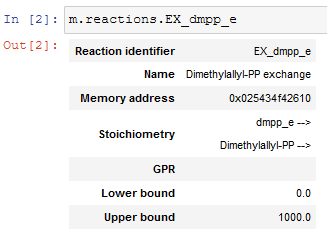

to

In [16]:
m.reactions.EX_dmpp_e

Reaction identifier,EX_dmpp_e
Name,Dimethylallyl-PP exchange
Memory address,0x01df41d506a0
Stoichiometry,dmpp_e --> DMPP_IPP_constraint Dimethylallyl-PP --> DMPP_IPP_constraint_e
GPR,
Lower bound,0.0
Upper bound,1000.0


It also removes the exchange reaction EX_ipdp_e shown below

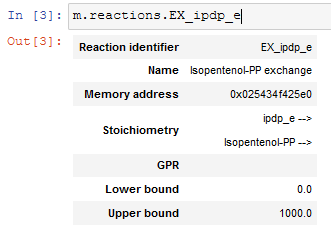

and the transport reaction IPPt.


### "adjust_model_reactions" function

The "adjust_model_reactions" function sets the initial conditions of the model for either aerobic or anaerobic.

In [17]:
def adjust_model_reactions(m, o_cond):
    #1. constrain the model to use 'PFK' instead of 'F6PA', 'DHAPT' when grown on glucose
    noFlux = ['F6PA', 'DHAPT'];
    for rxn in noFlux:
        m.reactions.get_by_id(rxn).lower_bound = 0.0
        m.reactions.get_by_id(rxn).upper_bound = 0.0
    
    #2. constrain the model to use the physiologically perferred glutamate synthesis enzymes (PMCID: 196288)
    m.reactions.GLUDy.upper_bound = 0
    m.reactions.GLUDy.lower_bound = 0

    #3. depending on oxygen availability, constrain the model to use the correct RNR enzymes (DOI:10.1111/j.1365-2958.2006.05493.x)
    # Dihydroorotate dehydrogenase (PyrD) (DOI:10.1016/S0076-6879(78)51010-0, PMID: 199252, DOI:S0969212602008316 [pii])
    aerobic = ['RNDR1', 'RNDR2', 'RNDR3', 'RNDR4', 'DHORD2', 'ASPO6','LCARR'] # see DOI:10.1111/j.1365-2958.2011.07593.x; see DOI:10.1089/ars.2006.8.773 for a review
    anaerobic = ['RNTR1c2', 'RNTR2c2', 'RNTR3c2', 'RNTR4c2', 'DHORD5', 'ASPO5'] # see DOI:10.1074/jbc.274.44.31291, DOI:10.1128/JB.00440-07
    if o_cond == 'aerobic':
        rxnList = aerobic
    else:
        rxnList = anaerobic
    for rxn in rxnList:
        m.reactions.get_by_id(rxn).lower_bound = 0.0
        m.reactions.get_by_id(rxn).upper_bound = 0.0


    #4. constrain fatty acid biosynthesis to use the physiologically preferred enzymes'''
    # Fatty acid biosynthesis: DOI: 10.1016/j.ymben.2010.10.007, PMCID: 372925
    fattyAcidSynthesis = ['ACCOAC', 'ACOATA', 'HACD1', 'HACD2', 'HACD3', 'HACD4', 'HACD5', 'HACD6', 'HACD7', 'HACD8', 'KAS14', 'KAS15', 'MACPD', 'MCOATA', '3OAR100', '3OAR120', '3OAR121', '3OAR140', '3OAR141', '3OAR160', '3OAR161', '3OAR180', '3OAR181', '3OAR40', '3OAR60', '3OAR80']
    fattyAcidOxidation = ['ACACT1r', 'ACACT2r', 'ACACT3r', 'ACACT4r', 'ACACT5r', 'ACACT6r', 'ACACT7r', 'ACACT8r', 'ACOAD1f', 'ACOAD2f', 'ACOAD3f', 'ACOAD4f', 'ACOAD5f', 'ACOAD6f', 'ACOAD7f', 'ACOAD8f', 'CTECOAI6', 'CTECOAI7', 'CTECOAI8', 'ECOAH1', 'ECOAH2', 'ECOAH3', 'ECOAH4', 'ECOAH5', 'ECOAH6', 'ECOAH7', 'ECOAH8']
    ndpk = ['NDPK1','NDPK2','NDPK3','NDPK4','NDPK5','NDPK7','NDPK8']
    rxnList = fattyAcidSynthesis + fattyAcidOxidation
    for rxn in rxnList:
        m.reactions.get_by_id(rxn).lower_bound = 0.0
        m.reactions.get_by_id(rxn).upper_bound = 1000.0
    
    #4. ATP maintenence
    m.reactions.get_by_id("ATPM").lower_bound = 0
    return m

## Create an aerobic COBRA model

In [18]:
m,ex_con = add_mev_pathway_to_cobra_model()
m = adjust_model_reactions(m,'aerobic')
solution = m.optimize(); # Changed from m.optimize(solver=gurobi)
print("solution:", solution.objective_value) # Growth-rate

solution: 0.9516149915266812


# Load metabolomics data

1. Load the data for all the different strains, including I1, I2, I3, L1, L2, L3, B1, B2, DH1(Wild Type).
2. Create a dictionary, "met_data," of all the metaboloics data for all the strains.
3. Create a Pandas Dataframe, "DF_metabolite_conc_all," of all the metabolomics data for all the strains.
4. Remove unwanted column heading for the "DF_metabolite_conc_all" dataframe.

In [19]:
# isopentenol producing strains
I1_data = pd.read_csv('./data/I1.csv',index_col=0)
I2_data = pd.read_csv('./data/I2.csv',index_col=0)
I3_data = pd.read_csv('./data/I3.csv',index_col=0)

# limonene producing strains
L1_data = pd.read_csv('./data/L1.csv',index_col=0)
L2_data = pd.read_csv('./data/L2.csv',index_col=0)
L3_data = pd.read_csv('./data/L3.csv',index_col=0)

# bisabolene producing strains
B1_data = pd.read_csv('./data/B1.csv',index_col=0)
B2_data = pd.read_csv('./data/B2.csv',index_col=0)

# wild-type strain
DH1_data = pd.read_csv('./data/DH1.csv',index_col=0)

# Dictionary of all strain data
met_data ={'I1':I1_data, 'I2':I2_data, 'I3':I3_data, 'L1':L1_data, 'L2':L2_data, 'L3':L3_data, 'B1':B1_data, 'B2':B2_data, 'DH1':DH1_data}

# Pandas dataframe of all strain data
DF_metabolite_conc_all = pd.DataFrame()
for strain in met_data.keys():
    DF_metabolite_conc_all = pd.concat([DF_metabolite_conc_all, met_data[strain]])

# Organize the pandas dataframe - drop columns not used in analysis

DF_metabolite_conc_all = DF_metabolite_conc_all.drop(['Cystine','Intracellular volume / sample','OD600','Sample','fold_production'],1)

C:\Users\A00016~1\AppData\Local\Temp\2/ipykernel_2208/4256532677.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  DF_metabolite_conc_all = DF_metabolite_conc_all.drop(['Cystine','Intracellular volume / sample','OD600','Sample','fold_production'],1)


Show the contents of the "DF_metabolite_conc_all" dataframe.

In [20]:
DF_metabolite_conc_all[0:20]

,Hour,Strain,glc__D_e,pyr_e,succ_e,lac__D_e,for_e,ac_e,ipoh_e,bis_e,lim_e,aacoa_c,hmgcoa_c,mev_R_c,5pmev_c,ipdp_c,ip_c,grdp_c,frdp_c,amp_c,adp_c,atp_c,nad_c,nadp_c,accoa_c,fdp_c,3pg_c,pep_c,pyr_c,lac__D_c,fum_c,succ_c,oxalcoa_c,mal__L_c,akg_c,acon__C_c,cit_c,icit_c,glx_c,glyclt_c,dxyl5p_c,2me4p,h2mb4p_c,2mecdp_c,4c2me_c,gly_c,ala__L_c,ser__L_c,pro__L_c,val__L_c,thr__L_c,cys__L_c,leu__L_c,ile__L_c,asn__L_c,asp__L_c,gln__L_c,lys__L_c,glu__L_c,met__L_c,his__L_c,phe__L_c,arg__L_c,tyr__L_c,trp__L_c,ex_con.id,ip_e,2mecdp_e,mev_R_e,dxyl5p_e,5pmev_e,h2mb4p_e,grdp_e,frdp_e,ggdp_e,4c2me_e,coa_e,accoa_e,aacoa_e,hmgcoa_e,amp_e,adp_e,atp_e,nad_e,nadh_e,nadp_e,nadph_e
0,0,I1,58.764,0.560,0.097,0.582,1.406,7.697,0.000,0.0,0.0,0,0.000e+00,3.480e-06,1.650e-05,0.003,0.000e+00,0.000e+00,0.0,1.714e-04,7.170e-05,2.214e-04,4.793e-04,6.080e-05,1.969e-04,0.005,1.310e-03,2.380e-05,2.564e-03,0.014,4.481e-04,2.844e-03,0,3.374e-04,3.900e-05,1.710e-05,5.150e-05,1.100e-06,2.703e-04,3.690e-05,5.710e-05,0,0,3.925e-04,2.930e-05,2.906e-03,1.211e-03,1.365e-02,1.991e-03,9.097e-04,9.989e-04,0,0.001,1.101e-03,5.063e-03,0.000e+00,7.755e-04,6.917e-04,0.012,2.882e-04,6.442e-04,0.003,0.003,1.517e-03,3.734e-04,9.640e-05,9.263e-04,0.000e+00,0.000e+00,0.0,0.000e+00,0.034,0.000e+00,0.0,0.000,0.000e+00,2.085e-04,0.000e+00,0,0.000,0.000e+00,0,0,0.0,0,0.0,0
1,2,I1,52.737,0.058,1.987,4.418,5.487,15.661,0.000,0.0,0.0,0,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0,0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.0,0.000e+00,0.000,0.000e+00,0.0,0.000,0.000e+00,0.000e+00,0.000e+00,0,0.000,0.000e+00,0,0,0.0,0,0.0,0
2,4,I1,48.139,0.045,1.906,6.749,2.060,18.430,0.692,0.0,0.0,0,6.890e-05,2.753e-04,9.387e-04,0.018,3.969e-03,0.000e+00,0.0,3.153e-04,1.891e-04,3.791e-04,1.829e-03,2.212e-04,4.923e-04,0.005,2.267e-03,5.040e-05,1.671e-04,0.124,5.649e-04,5.859e-03,0,4.579e-04,2.810e-05,6.220e-05,7.630e-05,4.670e-06,4.232e-04,1.011e-04,1.590e-04,0,0,9.146e-04,1.900e-05,3.544e-03,1.733e-03,1.958e-04,7.942e-03,8.314e-04,8.190e-05,0,0.002,6.488e-04,4.955e-04,0.000e+00,3.902e-04,8.716e-04,0.010,1.211e-04,9.417e-04,0.004,0.006,1.426e-03,3.711e-04,4.779e-03,3.391e-02,2.398e-04,7.932e-03,0.0,0.000e+00,0.000,0.000e+00,0.0,0.001,9.361e-04,0.000e+00,2.136e-04,0,0.002,0.000e+00,0,0,0.0,0,0.0,0
3,6,I1,44.761,0.111,1.936,9.657,2.775,20.056,0.000,0.0,0.0,0,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0,0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,4.650e-03,4.859e-02,6.099e-04,1.194e-02,0.0,0.000e+00,0.000,9.151e-04,0.0,0.010,1.396e-03,0.000e+00,0.000e+00,0,0.000,0.000e+00,0,0,0.0,0,0.0,0
4,8,I1,40.254,0.719,1.994,13.328,2.925,21.697,1.275,0.0,0.0,0,0.000e+00,5.951e-04,1.216e-03,0.017,3.298e-03,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.004,1.785e-03,4.380e-05,1.946e-03,0.213,5.233e-04,5.969e-03,0,4.227e-04,1.520e-05,8.630e-05,7.520e-05,3.520e-06,3.312e-04,9.500e-05,1.411e-04,0,0,7.889e-04,2.560e-05,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,4.413e-03,2.682e-02,0.000e+00,2.164e-02,0.0,3.952e-04,0.000,2.255e-03,0.0,0.005,2.627e-03,0.000e+00,0.000e+00,0,0.000,0.000e+00,0,0,0.0,

## Create models using metabolomics data to set constraints

### Constrain exchange reactions with phenotypic measurements

This function will perform the following operations:
- choose the constraints based on the phenotypic data
- calculate the flux from the phenotypic data
- create a cobra model based on those constrains

There are three phases that will be analyzed.

Phases:
- I: 0 to 4 (0 to 6 hours)
- II: 4 to 10 (8 to 20 hours)
- III: 10 to 13 (24 to 72 hours)

### Define the phases

In [21]:
# defined phases from metabolomics
phase1=[0,2,4,6]
phase2=[8,10,12,16,18,20]
phase3=[24,36,48]
all_time_points = [0,2,4,6,8,10,12,16,18,20,24,36,48]

### A function to set the fluxes for each phase of all the strains

The process includes:
1. Not constraining any cofactor secretions
2. Extrapolating for missing OD values
3. Converting mM concentrations to mmol/gDW*hr fluxes
4. Finding the average of fluxes for each reaction within each phase
5. Setting the reaction bounds in m model to the average flux of the specified phases

The function accepts the following arguments
1. df - A dataframe with the metaboilom,ics data for a given strain (eg. I3_data)
2. phase_times - The phase of interest (eg. phase1) 
3. m - The mevalonate model (eg. m)
4. strain - The strain of interest (eg. "I3")

The function returns the following,
1. fluxDict - A dictionary of the metabolomics based constraints for the requested phase (eg. I3_fluxdict_p1)
2. m - An updated model including the new constraints associated strain and phase.
3. avg_biomass - The average biomass for the strain and phase.
4. pd.DataFrame(read_to_struct) - A dataframe containing in the average flux for each reaction, phase and strain.

In [22]:
import math
import numpy as np
from numpy import log
import pytest

def set_fluxes_by_phase(df, phase_times, m, strain):
    read_to_struct = []
    constraints = []
    fluxDict={}

    # Do not constrain any cofactor secretions
    for i in df.columns:
        if "_e" in i and "nad" not in i and "amp" not in i and "adp" not in i and "atp" not in i and "coa" not in i:
            constraints.append(i)
        
    print('exchange reactions constrained by phenotypic data:\n \n', constraints, '\n')  

    for i in df.index[:-1]:
        fluxDict[df.Hour[i]] ={}       

        # Extrapolate for missing OD values:
        if df.OD600[i] == 0 and df.Hour[i] != 0:
            tmp = (df.OD600[i+1] - df.OD600[i-1])/2 + df.OD600[i-1]
            tmp2 = df.OD600[i+1]
        elif df.OD600[i+1] == 0:
            tmp = df.OD600[i]
            tmp2 = (df.OD600[i+2] - df.OD600[i])/2 + df.OD600[i]
 
        # Calculate to convert mM to mmol/gDW*hr
        gDWperLperOD600=0.65*tmp
        delta_t = df.Hour[i+1]-df.Hour[i]
        constant = (1/gDWperLperOD600)/(delta_t)
    
        fluxDict[df.Hour[i]]['biomass'] = abs((log(tmp2)- log(tmp))/(delta_t))
        
        for react in m.reactions: # Change react.startswidth to react.id.startswidth
          
            x = list(m.reactions.get_by_id(str(react.id)).metabolites)
            metab = [r.id for r in x]
            if react.id.startswith('EX') and metab[0] in constraints:
                met_temp = metab[0]
                fluxDict[df.Hour[i]][str(react.id)] = (df[str(met_temp)][i+1] - df[str(met_temp)][i])*(constant)
                
    # Find the average of fluxes for each reaction within the phase
    for j in fluxDict[0].keys():   
        if len(phase_times) == 3:  #phase 3
            phase_tmp = '24 to 72'
            avg_flux = np.average([fluxDict[phase_times[0]][j], fluxDict[phase_times[1]][j], fluxDict[phase_times[2]][j]])
            read_to_struct.append({ 'reaction':j, 'avg_flux':avg_flux,'phase':phase_tmp, 'strain':strain})
        if len(phase_times) == 6:  #phase 2
            phase_tmp = '8 to 20'
            avg_flux = np.average([fluxDict[phase_times[0]][j], fluxDict[phase_times[1]][j], fluxDict[phase_times[2]][j],fluxDict[phase_times[3]][j],fluxDict[phase_times[4]][j],fluxDict[phase_times[5]][j]])
            read_to_struct.append({ 'reaction':j, 'avg_flux':avg_flux,'phase':phase_tmp, 'strain':strain})
        if len(phase_times) == 4:  #phase 1
            phase_tmp = '0 to 6'           
            avg_flux = np.average([fluxDict[phase_times[0]][j], fluxDict[phase_times[1]][j], fluxDict[phase_times[2]][j], fluxDict[phase_times[3]][j]])
            read_to_struct.append({ 'reaction':j, 'avg_flux':avg_flux,'phase':phase_tmp, 'strain':strain})
        if len(phase_times) > 6:
            avg_flux = 0
        
    # Set the reaction bounds in m model to the average flux of the specified phase
        if j != 'biomass':
            m.reactions.get_by_id(str(j)).lower_bound = avg_flux
            if avg_flux < 0:
                m.reactions.get_by_id(str(j)).upper_bound = 0
            else:
                m.reactions.get_by_id(str(j)).upper_bound = avg_flux
        else:
            avg_biomass = avg_flux


    print('\n')        
    solution = m.optimize()
    print('solution: \n',(solution.objective_value),'\n')
    print('Exp. biomass: \n',(avg_biomass))
    
    return (fluxDict, m, avg_biomass,pd.DataFrame(read_to_struct))

### Data Analysis

#### Running FBA with phenotypic constraints  (e.g. strain I3)

In [23]:
m,ex_con = add_mev_pathway_to_cobra_model()
m = adjust_model_reactions(m, 'aerobic')

[I3_fluxdict_p1, m_I3_p1, I3_biomass_p1,I3data] = set_fluxes_by_phase(I3_data, phase1, m,'I3')

exchange reactions constrained by phenotypic data:
 
 ['glc__D_e', 'pyr_e', 'succ_e', 'lac__D_e', 'for_e', 'ac_e', 'ipoh_e', 'bis_e', 'lim_e', 'ip_e', '2mecdp_e', 'mev_R_e', 'dxyl5p_e', '5pmev_e', 'h2mb4p_e', 'grdp_e', 'frdp_e', 'ggdp_e', '4c2me_e'] 



solution: 
 0.10863626307366575 

Exp. biomass: 
 0.10590467207177083


#### The flux dictionary for the new model

In [24]:
I3_fluxdict_p1

{0: {'biomass': 0.17786894237385548,
  'EX_glc__D_e': -3.1759403569554485,
  'EX_ac_e': 3.348853027307233,
  'EX_lac__D_e': 0.15345850661177363,
  'EX_pyr_e': -0.76194522664726,
  'EX_succ_e': 0.993362826396247,
  'EX_for_e': 0.781292806732264,
  'EX_ipoh_e': 0.0,
  'EX_5pmev_e': 0.0,
  'EX_ip_e': 0.0,
  'EX_2mecdp_e': 0.0,
  'EX_dxyl5p_e': 0.0,
  'EX_h2mb4p_e': 0.0,
  'EX_grdp_e': 0.0,
  'EX_frdp_e': 0.0,
  'EX_ggdp_e': -0.006448169573558165,
  'EX_4c2me_e': -0.00034351434066916893,
  'EX_bis_e': 0.0,
  'EX_lim_e': 0.0},
 2: {'biomass': 0.1309296650980073,
  'EX_glc__D_e': -2.0091192325984433,
  'EX_ac_e': 1.1192448513549695,
  'EX_lac__D_e': 0.0934995521244289,
  'EX_pyr_e': -0.00046149997881423434,
  'EX_succ_e': -0.020339875403808334,
  'EX_for_e': -0.0049852342542083755,
  'EX_ipoh_e': 0.3273813091180507,
  'EX_5pmev_e': 0.00017026442703790544,
  'EX_ip_e': 0.04752996221042221,
  'EX_2mecdp_e': 0.0015526713158753947,
  'EX_dxyl5p_e': 0.0,
  'EX_h2mb4p_e': 0.0,
  'EX_grdp_e': 0.001

#### The new model based on phase and strain

In [25]:
m_I3_p1

Name,iJO1366
Memory address,0x01df40ad6670
Number of metabolites,1831
Number of reactions,2625
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


#### The average biomass value of the new model based on phase and strain

In [26]:
I3_biomass_p1

0.10590467207177083

#### The average flux data based on phase and strain

In [27]:
I3data

,reaction,avg_flux,phase,strain
0,biomass,1.059e-01,0 to 6,I3
1,EX_glc__D_e,-1.803e+00,0 to 6,I3
2,EX_ac_e,1.116e+00,0 to 6,I3
3,EX_lac__D_e,4.346e-02,0 to 6,I3
4,EX_pyr_e,-1.918e-01,0 to 6,I3
5,EX_succ_e,2.493e-01,0 to 6,I3
6,EX_for_e,2.995e-01,0 to 6,I3
7,EX_ipoh_e,1.868e-01,0 to 6,I3
8,EX_5pmev_e,6.975e-05,0 to 6,I3
9,EX_ip_e,8.587e-03,0 to 6,I3


## Running FBA on all strains, all phases of data

The results are stored in a dataframe that includes: Strain, Phase_in_hours, Solution, Strain/phase, average growth rate, and the average glucose flux. The fluxes are given in mmol/gDW*hr.

In [28]:
strain_name = []
sol =[]
phase_list = []
avg_biomass =[]
avg_glc_uptake=[]
for_graph=[]
df_temp  = []    
data = met_data.copy() 

for strain in data:
    print('strain:  ',strain)
    for phase in [phase1, phase2, phase3]:
        m, ex_con = add_mev_pathway_to_cobra_model()
        m = adjust_model_reactions(m,'aerobic')
        with suppress_stdout():
            [fluxdict, m_tmp, avg_biomass_tmp,tmp_data] = set_fluxes_by_phase(data[strain], phase, m, strain)
            solution = m_tmp.optimize()
            sol_tmp = solution.objective_value
        
        strain_name.append(strain)
        sol.append(sol_tmp)
        phase_tmp = str(phase[0])+" to "+str(phase[-1])
        phase_list.append(phase_tmp)
        avg_biomass.append(avg_biomass_tmp)
        avg_glc_uptake.append(m_tmp.reactions.get_by_id('EX_glc__D_e').lower_bound)
        if phase == phase1:
            for_graph.append(str(strain+'_p1'))
        elif phase == phase2:
            for_graph.append(str(strain+'_p2'))
        else:
            for_graph.append(str(strain+'_p3'))
                             
        count = 0
        for r in m.reactions:
            flux_tmp = m.reactions.get_by_id(r.id).flux
            
            if 'HMGR' in str(r) or 'HMGS' in str(r):
                flux_tmp = -flux_tmp 
            
            df_temp.append({'reaction':r.id, 'flux':flux_tmp, 'strain':strain, 'phase':phase_tmp})         
            count += 1
                             
DF_flux_all_strains = pd.DataFrame(df_temp)                
DF_FBA_results = pd.DataFrame({'Strain': strain_name,
                            'Phase_in_hours': phase_list,
                            'Solution': sol,
                            'Strain/phase':for_graph,
                              'Avg_growth_rate':avg_biomass,
                              'Avg_glc_flux': avg_glc_uptake})       

strain:   I1
strain:   I2
strain:   I3
strain:   L1
strain:   L2
strain:   L3
strain:   B1
strain:   B2
strain:   DH1


In [29]:
DF_FBA_results

,Strain,Phase_in_hours,Solution,Strain/phase,Avg_growth_rate,Avg_glc_flux
0,I1,0 to 6,4.861e-02,I1_p1,6.037e-02,-1.794
1,I1,8 to 20,8.762e-03,I1_p2,7.150e-03,-0.250
2,I1,24 to 48,2.197e-02,I1_p3,1.270e-03,-0.195
3,I2,0 to 6,7.596e-02,I2_p1,1.958e-01,-2.379
4,I2,8 to 20,8.411e-02,I2_p2,2.048e-02,-0.984
5,I2,24 to 48,7.144e-03,I2_p3,1.787e-03,-0.128
6,I3,0 to 6,1.086e-01,I3_p1,1.059e-01,-1.803
7,I3,8 to 20,6.450e-02,I3_p2,9.839e-03,-0.818
8,I3,24 to 48,1.050e-02,I3_p3,8.421e-04,-0.139
9,L1,0 to 6,7.527e-02,L1_p1,1.163e-01,-1.944


Note: fluxes given in mmol/gDW*hr

Simplifying the table

In [30]:
DF_FBA_results.set_index(['Strain','Phase_in_hours']).drop('Strain/phase',1)

C:\Users\A00016~1\AppData\Local\Temp\2/ipykernel_2208/3500375802.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  DF_FBA_results.set_index(['Strain','Phase_in_hours']).drop('Strain/phase',1)


Solution  Avg_growth_rate  Avg_glc_flux
Strain Phase_in_hours                                          
I1     0 to 6          4.861e-02        6.037e-02        -1.794
       8 to 20         8.762e-03        7.150e-03        -0.250
       24 to 48        2.197e-02        1.270e-03        -0.195
I2     0 to 6          7.596e-02        1.958e-01        -2.379
       8 to 20         8.411e-02        2.048e-02        -0.984
       24 to 48        7.144e-03        1.787e-03        -0.128
I3     0 to 6          1.086e-01        1.059e-01        -1.803
       8 to 20         6.450e-02        9.839e-03        -0.818
       24 to 48        1.050e-02        8.421e-04        -0.139
L1     0 to 6          7.527e-02        1.163e-01        -1.944
       8 to 20         2.693e-02        5.356e-03        -0.354
       24 to 48        3.666e-03        2.327e-04        -0.088
L2     0 to 6          1.426e-01        1.875e-01        -1.970
       8 to 20         5.117e-02        1.419e-02        -0.542
       24 to 48        1.419e-02        7.437e-04        -0.167
L3     0 to 6          1.168e-01        1.165e-01        -1.705
       8 to 20         4.176e-02        7.133e-03        -0.480
       24 to 48        1.032e-02        1.109e-03        -0.161
B1     0 to 6          9.018e-02        9.383e-02        -2.067
       8 to 20         1.819e-02        7.405e-03        -0.358
       24 to 48        6.114e-03        2.487e-03        -0.125
B2     0 to 6          1.140e-01        7.375e-02        -1.909
       8 to 20         4.253e-02        7.747e-03        -0.451
       24 to 48        3.061e-04        1.269e-03        -0.050
DH1    0 to 6          7.906e-02        5.549e-02        -1.508
       8 to 20         1.345e-02        6.912e-03        -0.282
       24 to 48        7.501e-03        4.880e-04        -0.136

## Graph showing the experimental growth rate vs FBA solution 

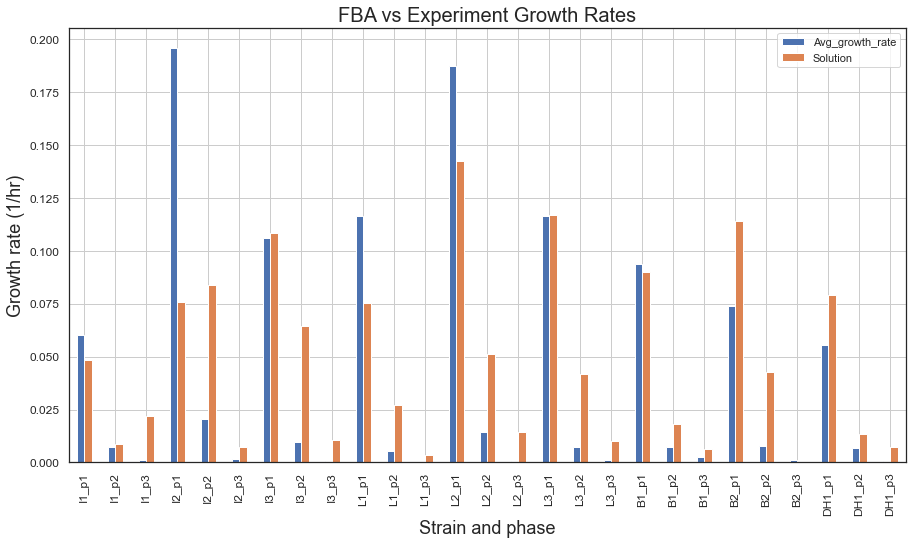

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

name_graph = 'FBA_vs_experiment_growth_rates'
df = DF_FBA_results.set_index(['Strain/phase'])

ax = df[['Avg_growth_rate','Solution']].plot(kind='bar', stacked=False,
                                           title = 'FBA_vs_experiment_growth_rates',
                                            figsize=(15,8), fontsize=12)
ax.set_ylabel("Growth rate (1/hr)",fontsize=18)
ax.set_xlabel("Strain and phase",fontsize=18)
ax.set_title('FBA vs Experiment Growth Rates', fontsize=20)
plt.grid()
plt.show()

## Plot the phases that correspond to growth rate 

The curves are the metabolomics data for each strain. The gray dots correspond to the average growth rate for each phase of the strain.

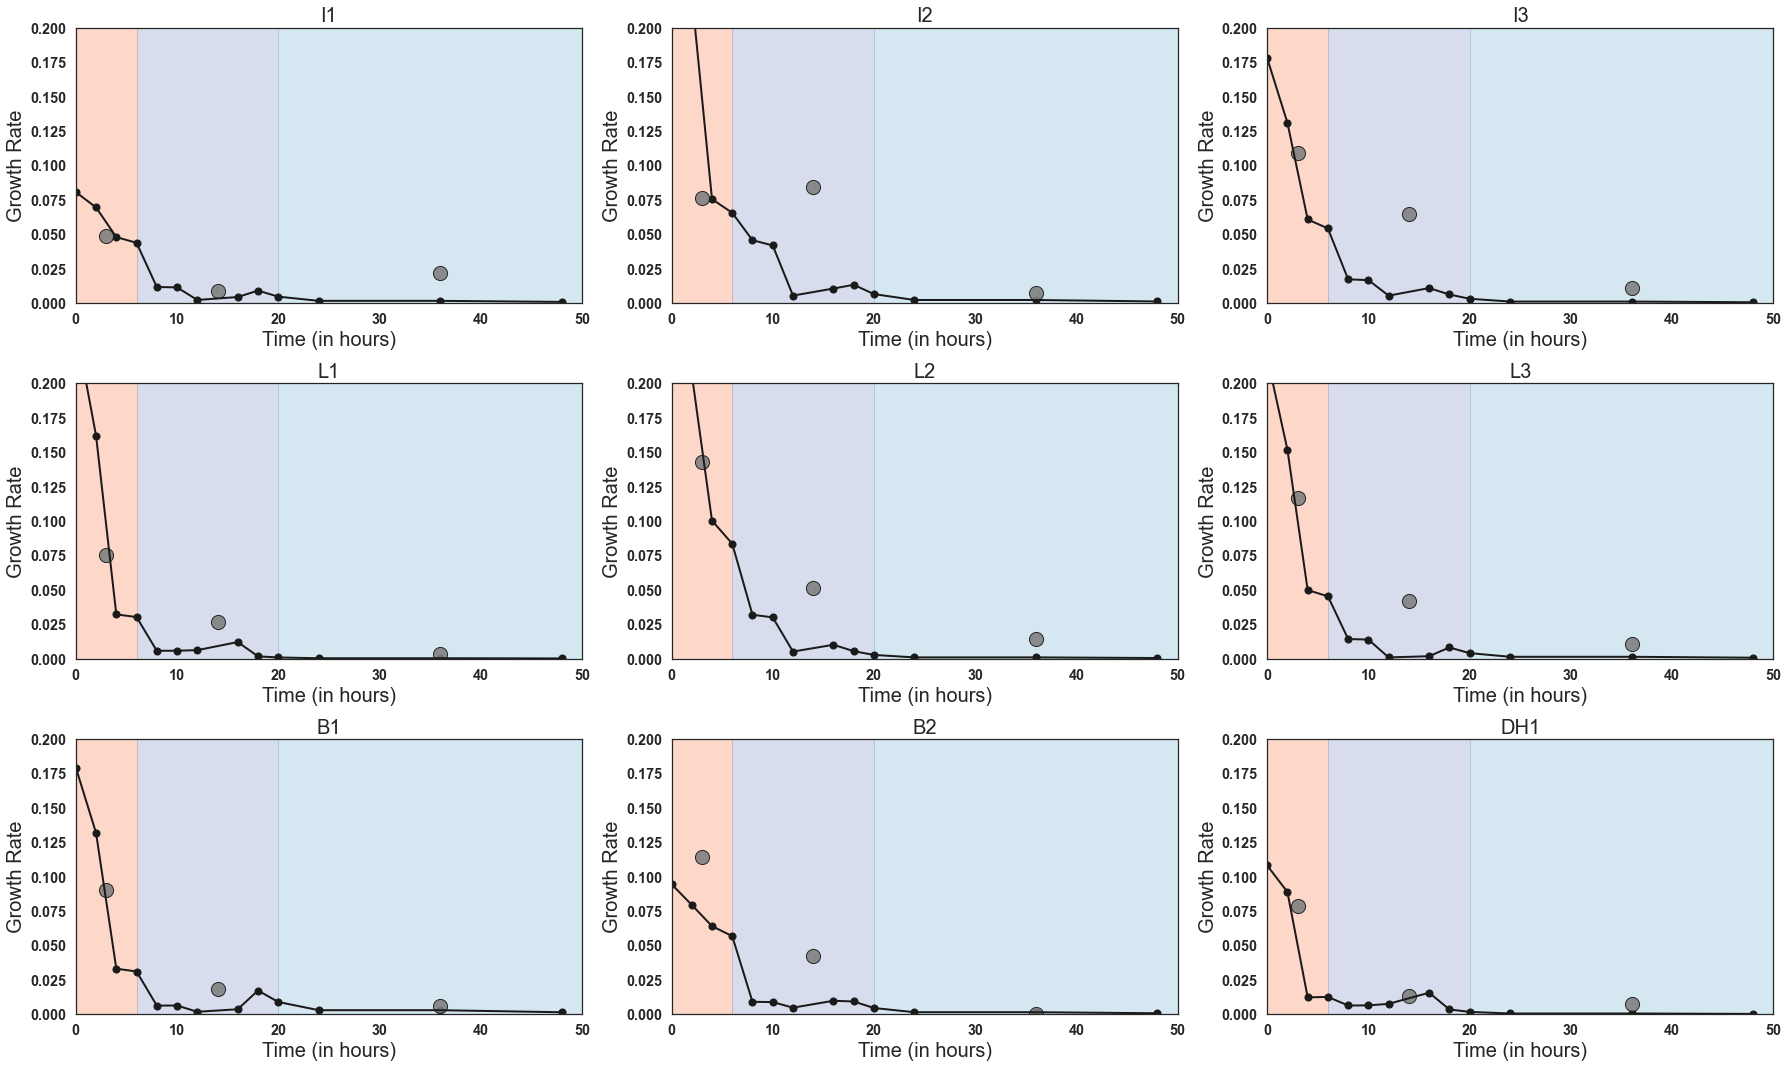

In [32]:
name_graph = 'phases_vs_growth_rate'

fig,axes = plt.subplots(3, 3, figsize=(25,15))

for k in range(0,len(data)):
    if k <3:
        l=0
        n=k
    elif k>2 and k<6:
        l=1
        n=k-3
    elif k>5:
        l=2
        n=k-6
    
    strain_tmp = list(data.keys())[k] ### Added
    
    tmp_biomass = []
    tmp_time = []
    
    with suppress_stdout():
        [fluxDict, tmp_m, tmp_avg_biomass,tmp_data] = set_fluxes_by_phase(data[strain_tmp], 
                                                                          all_time_points, m, strain)
    for i in fluxDict.keys():
        tmp_biomass.append(fluxDict[i]['biomass'])
        tmp_time.append(i)      

    axes[l,n].axvspan(0, 6, alpha=0.35, color=c2)
    axes[l,n].axvspan(6, 20, alpha=0.35, color=c3)
    axes[l,n].axvspan(20, 50, alpha=0.35, color=b3)        
        
    axes[l,n].plot(tmp_time,tmp_biomass, c='k',linewidth=2)
    axes[l,n].scatter(tmp_time,tmp_biomass, c='k',s=50)
    
    tmp_frame = DF_FBA_results[DF_FBA_results.Strain == strain_tmp]
    
    sol_list = tmp_frame.Solution.tolist()
    
    growth_rate_list= tmp_frame.Avg_growth_rate.tolist()
    
    time_list=[np.average([float(str(DF_FBA_results.Phase_in_hours.tolist()[0]).split(" to ")[0]), 
                           float(str(DF_FBA_results.Phase_in_hours.tolist()[0]).split(" to ")[1])]), 
               np.average([float(str(DF_FBA_results.Phase_in_hours.tolist()[1]).split(" to ")[0]), 
                           float(str(DF_FBA_results.Phase_in_hours.tolist()[1]).split(" to ")[1])]),
               np.average([float(str(DF_FBA_results.Phase_in_hours.tolist()[2]).split(" to ")[0]), 
                           float(str(DF_FBA_results.Phase_in_hours.tolist()[2]).split(" to ")[1])])] 
    
    axes[l,n].scatter(time_list,sol_list,s=200, facecolors='grey', edgecolors='k',alpha=.9)
    
    axes[l,n].set_xlabel('Time (in hours)', fontsize=20)
    axes[l,n].set_ylabel('Growth Rate', fontsize=20)
    axes[l,n].set_title(strain_tmp, fontsize=20)
    axes[l,n].set_ylim([0,0.2])
    axes[l,n].set_xlim([0, 50])
    
    for tick in axes[l,n].xaxis.get_ticklabels():
        tick.set_fontsize('large')
        tick.set_weight('bold')
    for tick in axes[l,n].yaxis.get_ticklabels():
        tick.set_fontsize('large')
        tick.set_weight('bold')
    
fig.tight_layout()


## Plot the phases that correspond to OD600 (biomass) for each strain and phase

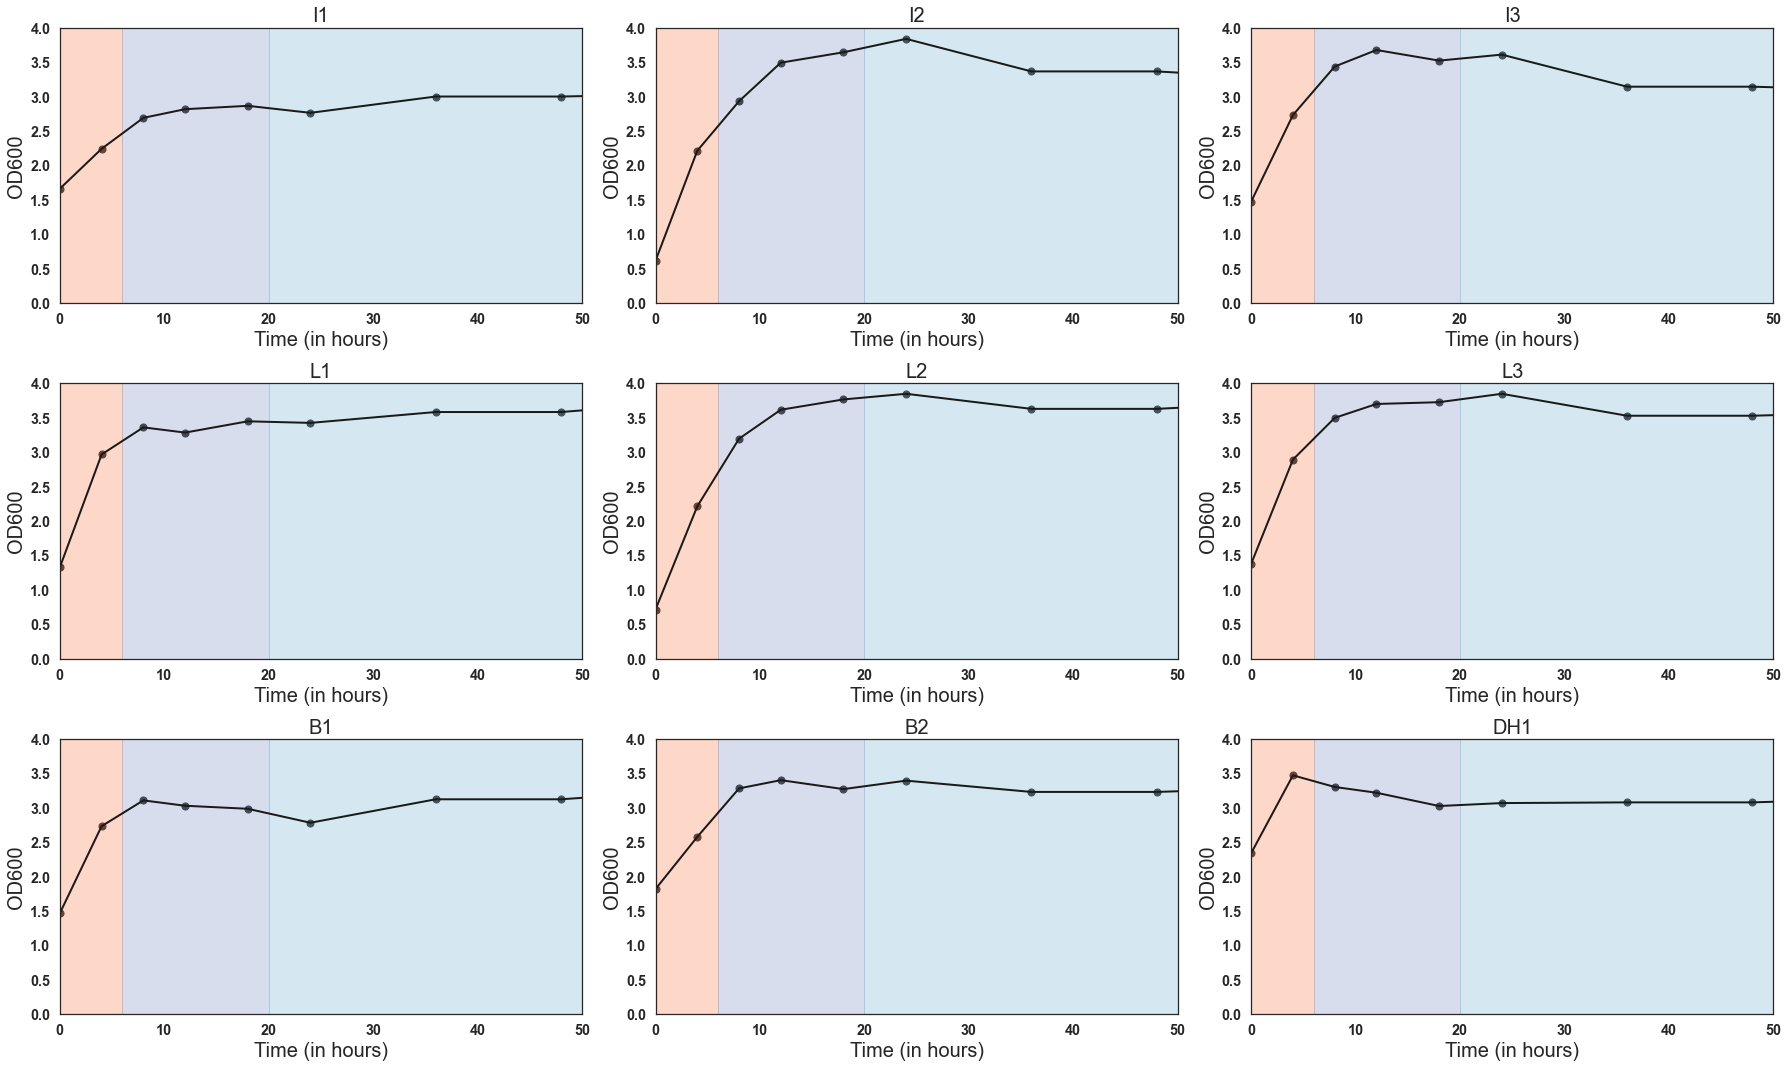

In [33]:
name_graph = 'phases_vs_OD600'
fig,axes = plt.subplots(3, 3, figsize=(25,15))

for k in range(0,len(data)):
    if k <3:
        l=0
        n=k
    elif k>2 and k<6:
        l=1
        n=k-3
    elif k>5:
        l=2
        n=k-6
    
    strain_tmp = list(data.keys())[k] ### Added
    tmp_OD = pd.Series([data[strain_tmp].OD600[i] for i in data[strain_tmp].index if data[strain_tmp].OD600[i] != 0])
    
    tmp_time_points = pd.Series([data[strain_tmp].Hour[i] for i in data[strain_tmp].index if data[strain_tmp].OD600[i] != 0])
    
    axes[l,n].plot(tmp_time_points,tmp_OD, c='k',linewidth=2)
    axes[l,n].scatter(tmp_time_points,tmp_OD, c='k',s=50)
    axes[l,n].set_xlabel('Time (in hours)', fontsize=20)
    axes[l,n].set_ylabel('OD600', fontsize=20)
    axes[l,n].set_title(strain_tmp, fontsize=20)
    axes[l,n].set_ylim([0, 4])
    axes[l,n].set_xlim([0, 50])  
    for tick in axes[l,n].xaxis.get_ticklabels():
        tick.set_fontsize('large')
        tick.set_weight('bold')
    for tick in axes[l,n].yaxis.get_ticklabels():
        tick.set_fontsize('large')
        tick.set_weight('bold')
        
    axes[l,n].axvspan(0, 6, alpha=0.35, color=c2)
    axes[l,n].axvspan(6, 20, alpha=0.35, color=c3)
    axes[l,n].axvspan(20, 50, alpha=0.35, color=b3)
                
fig.tight_layout()

## Reaction fluxes across strains across phases

### TALA reaction

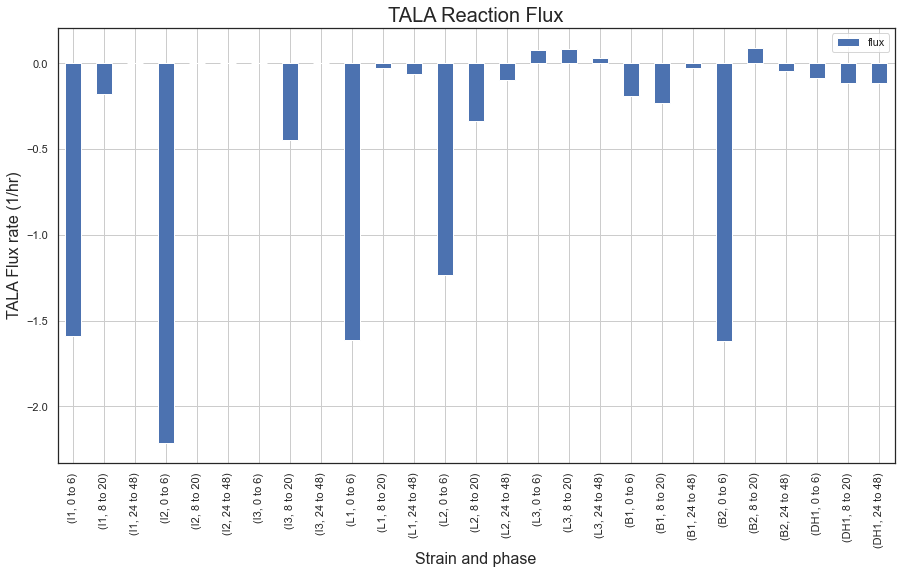

In [34]:
react = 'TALA'
df = DF_flux_all_strains[DF_flux_all_strains.strain.isin(['DH1','I1','I2','I3','L1','L2','L3','B1','B2'])][DF_flux_all_strains.reaction == react].set_index(['strain','phase'])

ax = df[['flux']].plot(kind='bar', stacked=False, figsize=(15,8))
ax.set_ylabel("TALA Flux rate (1/hr)", fontsize=16) 
ax.set_xlabel("Strain and phase", fontsize=16)
ax.set_title('TALA Reaction Flux', fontsize=20)
plt.grid()
plt.show()

### GND reaction

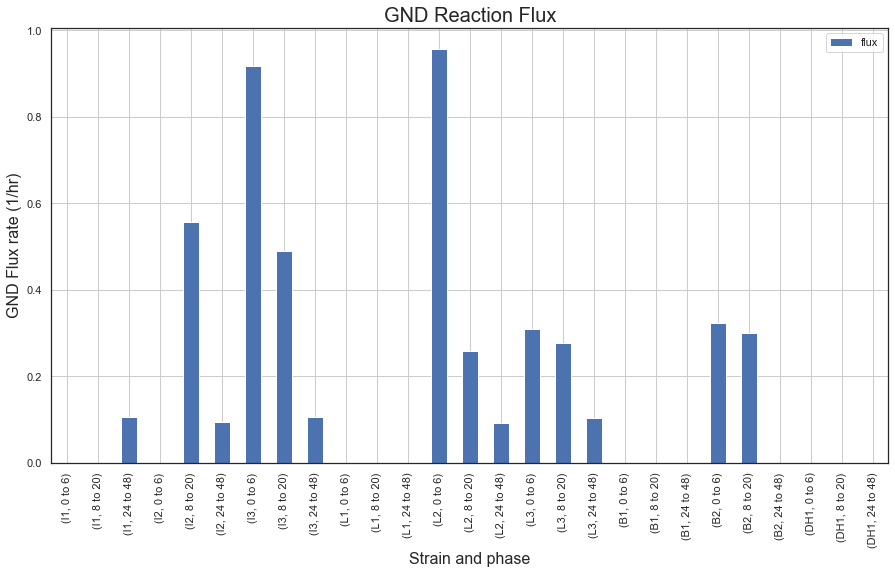

In [35]:
df = DF_flux_all_strains[DF_flux_all_strains.strain.isin(['DH1','I1','I2','I3','L1','L2','L3','B1','B2'])][DF_flux_all_strains.reaction == 'GND'].set_index(['strain','phase'])

ax = abs(df[['flux']]).plot(kind='bar', stacked=False, figsize=(15,8))
ax.set_ylabel("GND Flux rate (1/hr)", fontsize=16) 
ax.set_xlabel("Strain and phase", fontsize=16)
ax.set_title('GND Reaction Flux', fontsize=20)
plt.grid()
plt.show()

## Fluxes across strains and phases for reactions that produce NADPH

In [36]:
nadph_producers = []
for r in m.reactions:
    if m.reactions.get_by_id(r.id).reversibility == False:
        for mets in m.reactions.get_by_id(r.id).products:
            if 'nadph_c' in str(mets):
                nadph_producers.append({'reaction':r.id, 'name':m.reactions.get_by_id(r.id).name, 'stoich':m.reactions.get_by_id(r.id).reaction}) 
    else:
        for mets in m.reactions.get_by_id(r.id).metabolites:
            if 'nadph_c' in str(mets):
                nadph_producers.append({'reaction':r.id, 'name':m.reactions.get_by_id(r.id).name, 'stoich':m.reactions.get_by_id(r.id).reaction})
                
DF_NADPH_producers = pd.DataFrame(nadph_producers)
DF_NADPH_producers[0:10]

,reaction,name,stoich
0,5DGLCNR,5-dehydro-D-gluconate reductase,5dglcn_c + h_c + nadph_c <=> glcn_c + nadp_c
1,AGPR,N-acetyl-g-glutamyl-phosphate reductase,acg5sa_c + nadp_c + pi_c <=> acg5p_c + h_c + n...
2,ALDD2y,"Aldehyde dehydrogenase (acetaldehyde, NADP)",acald_c + h2o_c + nadp_c --> ac_c + 2.0 h_c + ...
3,ALDD3y,"Aldehyde dehydrogenase (propanal, NADP)",h2o_c + nadp_c + ppal_c --> 2.0 h_c + nadph_c ...
4,ATHRDHr,L-allo-threonine dehydrogenase,athr__L_c + nadp_c <=> 2aobut_c + h_c + nadph_c
5,BETALDHy,Betaine-aldehyde dehydrogenase,betald_c + h2o_c + nadp_c --> glyb_c + 2.0 h_c...
6,DHFR,Dihydrofolate reductase,dhf_c + h_c + nadph_c <=> nadp_c + thf_c
7,DSERDHr,D-serine dehydrogenase,nadp_c + ser__D_c <=> 2amsa_c + h_c + nadph_c
8,ASAD,Aspartate-semialdehyde dehydrogenase,aspsa_c + nadp_c + pi_c <=> 4pasp_c + h_c + na...
9,G3PD2,Glycerol-3-phosphate dehydrogenase (NADP),glyc3p_c + nadp_c <=> dhap_c + h_c + nadph_c


### Total sum of flux across strains for NADPH producing reactions

In [37]:
read_to_struct =[]

print('DF_flux_all_strains.strain.unique:  ',DF_flux_all_strains.strain.unique())

for s in DF_flux_all_strains.strain.unique():
    for p in DF_flux_all_strains.phase.unique():
        flux_sum = np.sum(DF_flux_all_strains[(DF_flux_all_strains.strain == s) & 
                                              (DF_flux_all_strains.phase == p) & 
                                              (DF_flux_all_strains.reaction.isin(DF_NADPH_producers.reaction.tolist()))].flux.values)
        
        read_to_struct.append({'strain':s, 'phase':p, 'summed_flux':flux_sum})
        
DF_sum_flux_from_NADPH = pd.DataFrame(read_to_struct)
DF_sum_flux_from_NADPH[0:20]

DF_flux_all_strains.strain.unique:   ['I1' 'I2' 'I3' 'L1' 'L2' 'L3' 'B1' 'B2' 'DH1']


,strain,phase,summed_flux
0,I1,0 to 6,0.798
1,I1,8 to 20,0.155
2,I1,24 to 48,0.326
3,I2,0 to 6,1.192
4,I2,8 to 20,1.631
5,I2,24 to 48,0.216
6,I3,0 to 6,1.871
7,I3,8 to 20,1.363
8,I3,24 to 48,0.309
9,L1,0 to 6,1.073


## Plot the total sum of flux across strains for NADPH producing reactions

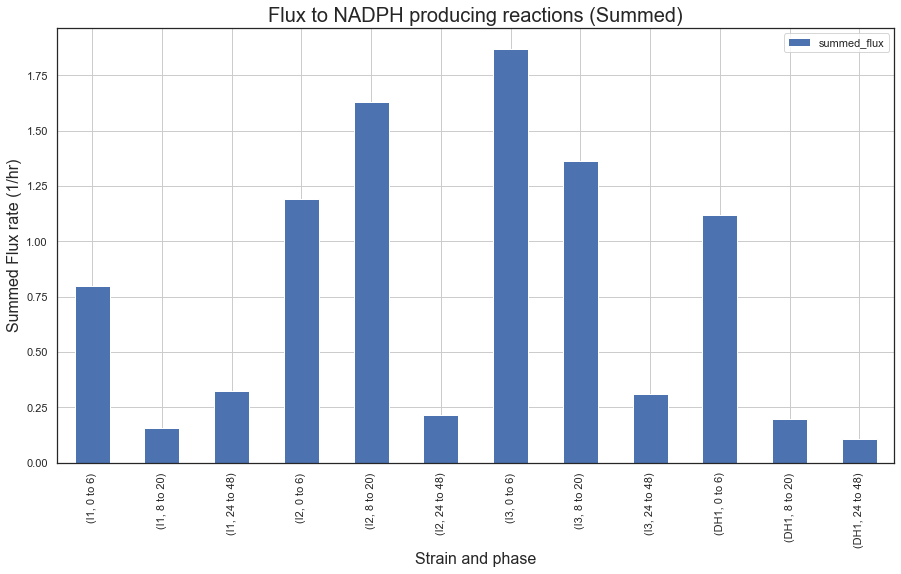

In [38]:
df = DF_sum_flux_from_NADPH[DF_sum_flux_from_NADPH.strain.isin(['DH1','I1','I2','I3'])].set_index(['strain','phase'])

ax = abs(df[['summed_flux']]).plot(kind='bar', stacked=False, figsize=(15,8))
ax.set_ylabel("Summed Flux rate (1/hr)", fontsize=16) 
ax.set_xlabel("Strain and phase", fontsize=16)
ax.set_title('Flux to NADPH producing reactions (Summed)', fontsize=20)
plt.grid()
plt.show()

## Save constrained models for the different strains and phases

The lower bounds on biomass were relaxed by 20%

In [ ]:
import cobra.test
for strain in data:
    for phase in [phase1, phase2, phase3]:
        m, ex_con = add_mev_pathway_to_cobra_model()
        m = adjust_model_reactions(m,'aerobic')
        with suppress_stdout():
            [fluxdict, m_tmp, avg_biomass_tmp,data_tmp] = set_fluxes_by_phase(data[strain], phase, m, strain)
            solution = m_tmp.optimize()
            sol_tmp = solution.objective_value
        
        # set upper and lower bounds for biomass based on solution or average growth rate for phase
        if sol_tmp < avg_biomass_tmp:    
            m.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').upper_bound = avg_biomass_tmp  
            m.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').lower_bound = sol_tmp - sol_tmp*0.2
            
        else:
            m.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').upper_bound = sol_tmp  
            m.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').lower_bound = avg_biomass_tmp - avg_biomass_tmp*0.2 
        
        # construct name for the file:
        strain_name = str(data[strain].Strain[0:1].tolist()[0])
        phase_tmp = str(phase[0])+"_"+str(phase[-1])
        file_name = strain_name + "_%s"%phase_tmp
        
        # Save json versions of the models
        output_filename = '%s.json' %file_name
        print(output_filename)
        # Verify the model ws saved
        cobra.io.json.save_json_model(m, output_filename) # Save as json file
        ecoli_json = '%s.json' %file_name
        ecoli_from_json = cobra.io.json.load_json_model(ecoli_json) 
        
        # Saving matlab versions of the models
        '''
        output_filename = '%s.mat' %file_name
        print(output_filename)
        cobra.io.save_matlab_model(ecoli_from_json, output_filename) 
        '''

I1_0_6.json
I1_8_20.json
I1_24_48.json
I2_0_6.json
I2_8_20.json
I2_24_48.json
I3_0_6.json
I3_8_20.json
I3_24_48.json
L1_0_6.json
L1_8_20.json
L1_24_48.json
L2_0_6.json
L2_8_20.json
L2_24_48.json
L3_0_6.json
L3_8_20.json
L3_24_48.json
B1_0_6.json
B1_8_20.json
B1_24_48.json
B2_0_6.json
B2_8_20.json
